In [1]:
from statsbombpy import sb
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
from IPython.display import display
from mplsoccer import Sbopen, Pitch
import numpy as np


parser = Sbopen()
pitch = Pitch(line_zorder=2)

## PT-Carregamento e Limpeza dos dados
## ENG-Data Loading and Cleaning

In [2]:
#Cria o dataframe com todas as partidas da Bundeliga temporada 2015/16
bundesliga_1516_matches = sb.matches(competition_id=9, season_id=27)

In [3]:
#Cria o dataframe com todas as partidas da Bundeliga do Monchengladbach na temporada 2015/16
matches_df = bundesliga_1516_matches[(bundesliga_1516_matches['home_team'] == 'Borussia Mönchengladbach') | (bundesliga_1516_matches['away_team'] == 'Borussia Mönchengladbach')]

In [4]:
match_ids = matches_df.match_id.unique()
all_events_df = []
for match_id in match_ids:
    # Obter os eventos da partida
    event = parser.event(match_id)[0]
    all_events_df.append(event)
event_ = pd.concat(all_events_df)
event_team = event_[event_['team_name'] == 'Borussia Mönchengladbach']


## PT-Análise do xG
## ENG-xG Analysis

In [ ]:
xg_by_player = event_team.groupby('player_name')['shot_statsbomb_xg'].sum().reset_index()
xg_by_player.rename(columns={'shot_statsbomb_xg': 'total_xg'}, inplace=True)
xg_by_player = xg_by_player.sort_values(by='total_xg', ascending=False)
display(xg_by_player)

,player_name,total_xg
10,Lars Edi Stindl,8.805573
19,Raffael Caetano de Araújo,7.982205
21,Thorgan Hazard,6.505971
1,André Hahn,3.829528
3,Fabian Johnson,3.550033
6,Ibrahima Traoré,3.037941
11,Mahmoud Dahoud,2.966605
0,Andreas Christensen,2.721779
4,Granit Xhaka,2.370882
18,Patrick Herrmann,1.869249


In [6]:
event_gol = event_team[event_team['outcome_name'] == 'Goal']
squad = pd.DataFrame({'player_name': event_team['player_name'].unique()})

In [7]:
goals_by_player = event_gol.groupby('player_name').size().reset_index(name='Gols')
goals_by_player = pd.merge(squad, goals_by_player, on = 'player_name', how = 'left')
goals_by_player['Gols'] = goals_by_player['Gols'].fillna(0)


In [8]:
xg_and_goals_by_player = pd.merge(goals_by_player, xg_by_player, on=['player_name'])
xg_and_goals_by_player['Diferença_entre_xG_Gol'] = xg_and_goals_by_player['Gols'] - xg_and_goals_by_player['total_xg']
xg_and_goals_by_player = xg_and_goals_by_player.sort_values(by='Diferença_entre_xG_Gol', ascending=True)
xg_and_goals_by_player = xg_and_goals_by_player[xg_and_goals_by_player['Diferença_entre_xG_Gol'] != 0]
display(xg_and_goals_by_player)

,player_name,Gols,total_xg,Diferença_entre_xG_Gol
7,Thorgan Hazard,4.0,6.505971,-2.505971
15,Lars Edi Stindl,7.0,8.805573,-1.805573
8,Jonas Hofmann,0.0,0.963086,-0.963086
13,Tony Jantschke,0.0,0.211580,-0.211580
3,Nico Elvedi,0.0,0.210491,-0.210491
22,Branimir Hrgota,0.0,0.171070,-0.171070
21,Martin Hinteregger,0.0,0.156503,-0.156503
12,Roel Brouwers,0.0,0.080365,-0.080365
9,Ibrahima Traoré,3.0,3.037941,-0.037941
4,Marvin Schulz,0.0,0.031731,-0.031731


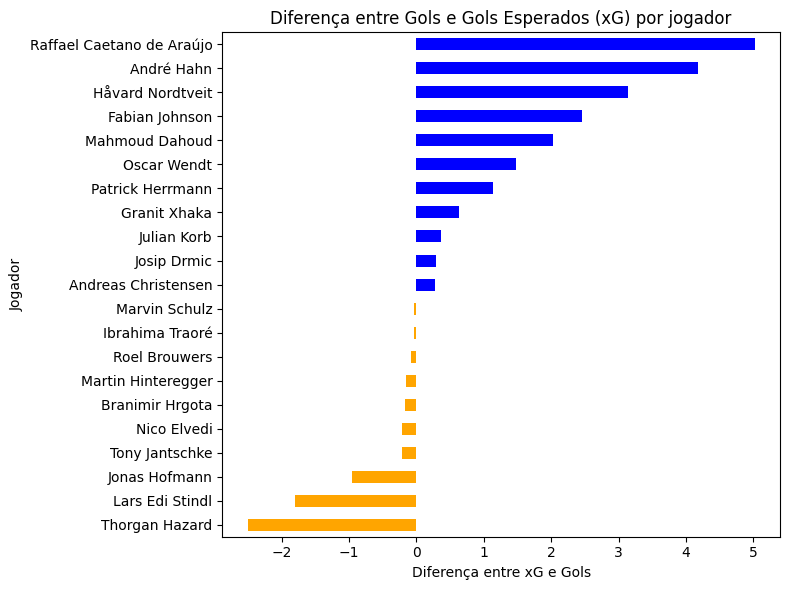

In [9]:
cores = xg_and_goals_by_player['Diferença_entre_xG_Gol'].apply(lambda x: 'blue' if x > 0 else 'orange')
fig, ax = plt.subplots(figsize = (8, 6))
xg_and_goals_by_player.plot.barh(x = 'player_name', y = 'Diferença_entre_xG_Gol', color = cores, ax=ax, legend = False)

ax.set_xlabel('Diferença entre xG e Gols')
ax.set_ylabel('Jogador')
plt.title('Diferença entre Gols e Gols Esperados (xG) por jogador')

plt.tight_layout()
plt.show()

## PT-Aplicação do modelo de xT
## ENG-Implementation of the xT model

In [10]:
bins = (12, 9)
#bins = (pitch.dim.positional_x[[0, 3, 4, 5, 6]], pitch.dim.positional_y)

In [11]:
all_events_df2 = []
set_pieces = ['Throw-in', 'Free Kick', 'Goal Kick', 'Corner', 'Kick Off', 'Penalty']
cols = ['match_id', 'id', 'team_name', 'type_name', 'sub_type_name', 'player_name',
        'x', 'y', 'end_x', 'end_y', 'outcome_name', 'shot_statsbomb_xg']

for match_id in match_ids:
    event2 = parser.event(match_id)[0]
    event2 = event2.loc[((event2.type_name.isin(['Carry', 'Shot', 'Pass'])) &
                       (~event2['sub_type_name'].isin(set_pieces))),
                       cols].copy()
    event2['goal'] = event2['outcome_name'] == 'Goal'
    event2['shoot'] = event2['type_name'] == 'Shot'
    event2['move'] = event2['type_name'] != 'Shot' 
    all_events_df2.append(event2)
event2 = pd.concat(all_events_df2)

In [12]:
event_time_xT =  event2[event2['team_name'] == 'Borussia Mönchengladbach']

In [13]:
shot_probability = pitch.bin_statistic(event_time_xT['x'], event_time_xT['y'], values=event_time_xT['shoot'],
                                       statistic='mean', bins=bins)
move_probability = pitch.bin_statistic(event_time_xT['x'], event_time_xT['y'], values=event_time_xT['move'],
                                       statistic='mean', bins=bins)
goal_probability = pitch.bin_statistic(event_time_xT.loc[event_time_xT['shoot'], 'x'],
                                       event_time_xT.loc[event_time_xT['shoot'], 'y'],
                                       event_time_xT.loc[event_time_xT['shoot'], 'shot_statsbomb_xg'],
                                       statistic='mean',
                                       bins=bins)

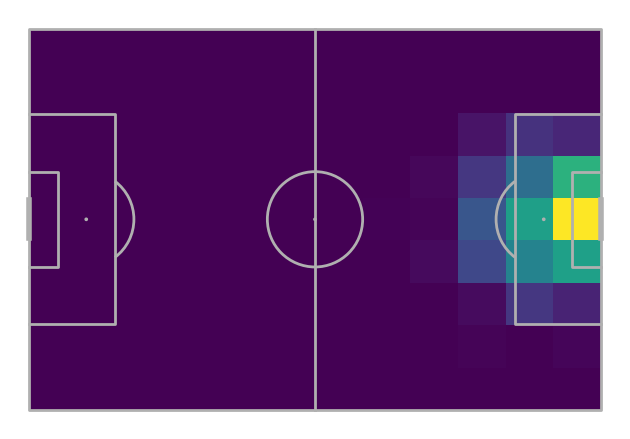

In [14]:
fig, ax = pitch.draw()
shot_heatmap = pitch.heatmap(shot_probability, ax=ax)


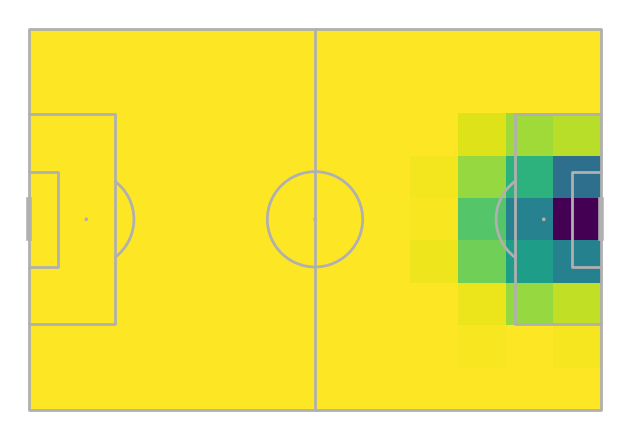

In [15]:
fig, ax = pitch.draw()
move_heatmap = pitch.heatmap(move_probability, ax=ax)


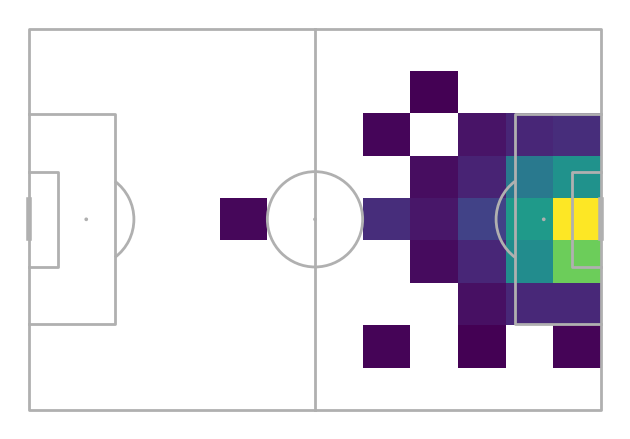

In [16]:
fig, ax = pitch.draw()
goal_heatmap = pitch.heatmap(goal_probability, ax=ax)


In [17]:
# get a dataframe of move events and filter it
# so the dataframe only contains actions inside the pitch.
move = event_time_xT[event_time_xT['move']].copy()
bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins=bins)
move = move[bin_start_locations['inside']].copy()

# get the successful moves, which filters out the events that ended outside the pitch
# or where not successful (null)
bin_end_locations = pitch.bin_statistic(move['end_x'], move['end_y'], bins=bins)
move_success = move[(bin_end_locations['inside']) & (move['outcome_name'].isnull())].copy()

# get a dataframe of the successful moves
# and the grid cells they started and ended in
bin_success_start = pitch.bin_statistic(move_success['x'], move_success['y'], bins=bins)
bin_success_end = pitch.bin_statistic(move_success['end_x'], move_success['end_y'], bins=bins)
df_bin = pd.DataFrame({'x': bin_success_start['binnumber'][0],
                       'y': bin_success_start['binnumber'][1],
                       'end_x': bin_success_end['binnumber'][0],
                       'end_y': bin_success_end['binnumber'][1]})

# calculate the bin counts for the successful moves, i.e. the number of moves between grid cells
bin_counts = df_bin.value_counts().reset_index(name='bin_counts')

# create the move_transition_matrix of shape (num_y_bins, num_x_bins, num_y_bins, num_x_bins)
# this is the number of successful moves between grid cells.
num_y, num_x = shot_probability['statistic'].shape
move_transition_matrix = np.zeros((num_y, num_x, num_y, num_x))
move_transition_matrix[bin_counts['y'], bin_counts['x'],
                       bin_counts['end_y'], bin_counts['end_x']] = bin_counts.bin_counts.values

# and divide by the starting locations for all moves (including unsuccessful)
# to get the probability of moving the ball successfully between grid cells
bin_start_locations = pitch.bin_statistic(move['x'], move['y'], bins=bins)
bin_start_locations = np.expand_dims(bin_start_locations['statistic'], (2, 3))
move_transition_matrix = np.divide(move_transition_matrix,
                                   bin_start_locations,
                                   out=np.zeros_like(move_transition_matrix),
                                   where=bin_start_locations != 0,
                                   )

In [18]:
move_transition_matrix = np.nan_to_num(move_transition_matrix)
shot_probability_matrix = np.nan_to_num(shot_probability['statistic'])
move_probability_matrix = np.nan_to_num(move_probability['statistic'])
goal_probability_matrix = np.nan_to_num(goal_probability['statistic'])


In [19]:
xt = np.multiply(shot_probability_matrix, goal_probability_matrix)
diff = 1
iteration = 0
while np.any(diff > 0.00001):  # iterate until the differences between the old and new xT is small
    xt_copy = xt.copy()  # keep a copy for comparing the differences
    # calculate the new expected threat
    xt = (np.multiply(shot_probability_matrix, goal_probability_matrix) +
          np.multiply(move_probability_matrix,
                      np.multiply(move_transition_matrix, np.expand_dims(xt, axis=(0, 1))).sum(
                          axis=(2, 3)))
          )
    diff = (xt - xt_copy)
    iteration += 1
print('Number of iterations:', iteration)

Number of iterations: 44


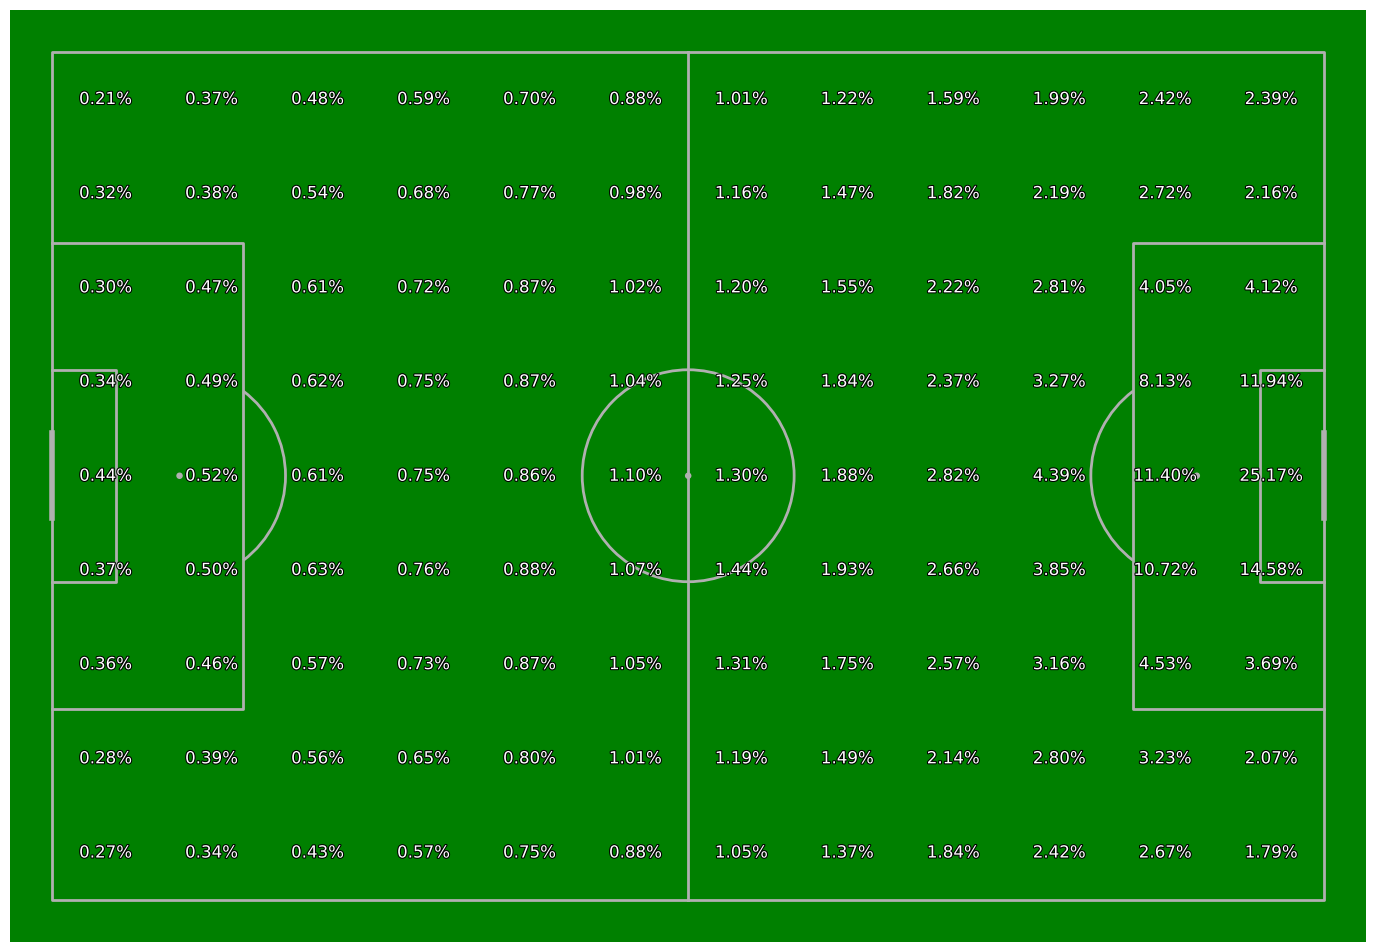

In [20]:
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

# new bin statistic for plotting xt only (se necessário para cálculos internos)
for_plotting = pitch.bin_statistic(event['x'], event['y'], bins=bins)
for_plotting['statistic'] = xt

# Desenha o campo normalmente, sem o heatmap
fig, ax = pitch.draw(figsize=(14, 9.625))

# Definir o fundo do eixo para verde
ax.set_facecolor('green')

# Se você quiser adicionar labels de porcentagem no campo, pode deixar a label_heatmap
_ = pitch.label_heatmap(for_plotting, ax=ax, str_format='{:.2%}',
                        color='white', fontsize=12, va='center', ha='center',
                        path_effects=path_eff)


## PT-Análise do xT
## ENG-xT Analysis


In [21]:
action_start = pitch.bin_statistic(move_success.x, move_success.y, bins = bins)
action_end = pitch.bin_statistic(move_success.end_x, move_success.end_y, bins = bins)

start_xT = xt[action_start['binnumber'][1], action_start['binnumber'][0]]
end_xT = xt[action_end['binnumber'][1], action_end['binnumber'][0]]

xT_total = end_xT - start_xT

move_success['xT'] = xT_total

xT_total_by_player = move_success.groupby('player_name')['xT'].sum().sort_values(ascending = False)
display(xT_total_by_player)

player_name
Raffael Caetano de Araújo    5.255004
Oscar Wendt                  4.291982
Ibrahima Traoré              4.191776
Granit Xhaka                 3.763732
Håvard Nordtveit             3.525846
Lars Edi Stindl              2.582885
Thorgan Hazard               2.582567
Fabian Johnson               2.441863
Andreas Christensen          2.193609
Mahmoud Dahoud               2.186344
Julian Korb                  2.152614
Nico Elvedi                  1.896226
Patrick Herrmann             1.727620
Yann Sommer                  1.517466
Tony Jantschke               0.854592
Martin Hinteregger           0.637224
Jonas Hofmann                0.508661
Álvaro Domínguez Soto        0.325796
André Hahn                   0.323284
Marvin Schulz                0.261955
Martin Stranzl               0.122431
Roel Brouwers                0.114210
Nico Schulz                  0.086116
Tobias Sippel                0.057534
Branimir Hrgota              0.045043
Josip Drmic                  0.004369


In [ ]:
min_jog = pd.read_csv("..\Borussia\minutos_por_jogador.csv")
min_jog.rename(columns={'Player': 'player_name'}, inplace=True)

In [23]:
xT_total_by_player = xT_total_by_player.to_frame()
xT_total_by_player["xT"] = pd.to_numeric(xT_total_by_player['xT'], errors='raise')
type(xT_total_by_player['xT'])
xT_total_by_player.reset_index(inplace=True)
xT_total_by_player.rename(columns={'index': 'player_name'}, inplace=True)



In [24]:
xT_total_by_player['player_name'] = xT_total_by_player['player_name'].replace({
    'Raffael Caetano de Araújo': 'Raffael Caetano',
    'Lars Edi Stindl': 'Lars Stindl',
    'Josip Drmic': 'Josip Drmić',
    'Álvaro Domínguez Soto': 'Álvaro Domínguez'
})

In [25]:
xT_by_player = pd.merge(xT_total_by_player[['player_name', 'xT']],
                          min_jog[['player_name', 'MP', 'Starts', 'Min', '90s']],
                          on = 'player_name')

In [26]:
xT_by_player["xT_90"] = xT_by_player["xT"] / xT_by_player["90s"]
xT_by_player = xT_by_player.sort_values(by='xT', ascending=True)



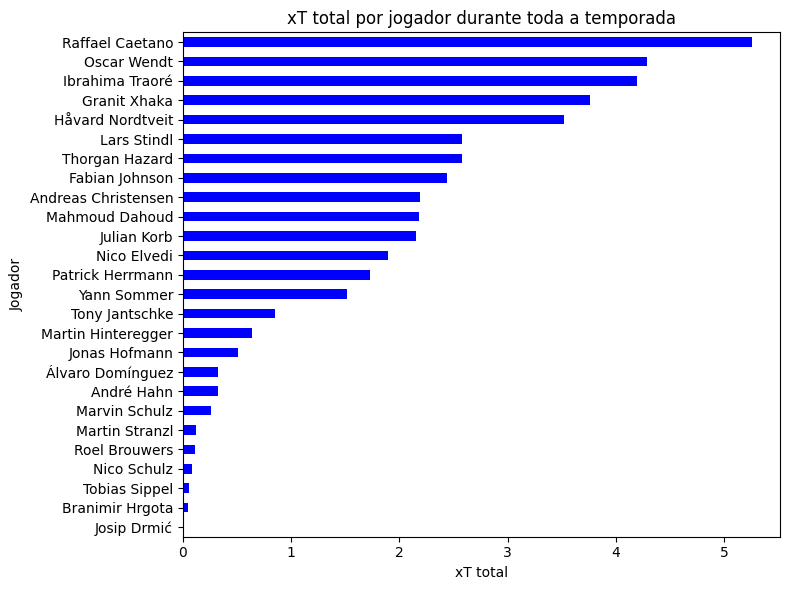

In [27]:
cores = xT_by_player['xT'].apply(lambda x: 'blue' if x > 0 else 'orange')
fig, ax = plt.subplots(figsize = (8, 6))
xT_by_player.plot.barh(x = 'player_name', y = 'xT', color = cores, ax=ax, legend = False)

ax.set_xlabel('xT total')
ax.set_ylabel('Jogador')
plt.title('xT total por jogador durante toda a temporada')

plt.tight_layout()
plt.show()

In [28]:
xT_by_player = xT_by_player.sort_values(by='xT_90', ascending=True)


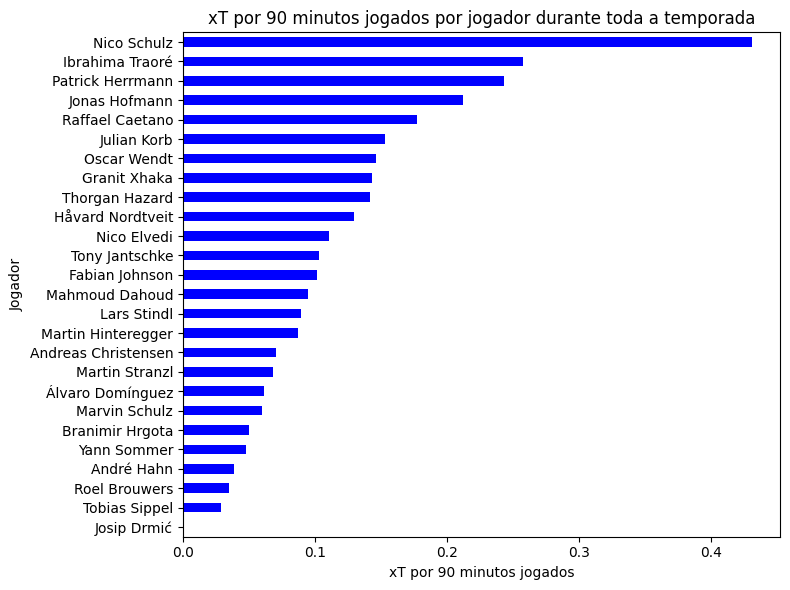

In [29]:
cores = xT_by_player['xT_90'].apply(lambda x: 'blue' if x > 0 else 'orange')
fig, ax = plt.subplots(figsize = (8, 6))
xT_by_player.plot.barh(x = 'player_name', y = 'xT_90', color = cores, ax=ax, legend = False)

ax.set_xlabel('xT por 90 minutos jogados')
ax.set_ylabel('Jogador')
plt.title('xT por 90 minutos jogados por jogador durante toda a temporada')

plt.tight_layout()
plt.show()